# Ejercicio 1

# Ejercicio 2

# Ejercicio 3

# Ejercicio 4

Implementar en Python los tres algoritmos vistos en clase para hallar los ceros de una función `f : [a, b] → ℝ`:

- método de bisección  
- método de la secante  
- método de Newton‑Raphson  

Como parámetros, sus algoritmos deben recibir la función `f`, la derivada `df` (en el caso de Newton), el intervalo `[a, b]` o el punto inicial de búsqueda `x0 ∈ ℝ`. Así como los criterios de paro `iter` y `tol > 0`.  

Para la salida, sus funciones deben devolver la lista de aproximaciones realizadas y el valor de punto `x*` donde se encontró el cero.


In [3]:
def metodo_biseccion(f, a, b, tol=1e-6, iter_max=100):
    """
    Encuentra un cero de la función f en el intervalo [a, b] usando el método de bisección.
    
    Parámetros:
    - f: función a la que se le busca el cero
    - a, b: extremos del intervalo [a, b]
    - tol: tolerancia para el criterio de parada
    - iter_max: número máximo de iteraciones permitidas
    
    Retorna:
    - aproximaciones: lista de aproximaciones generadas
    - x: aproximación final del cero
    """
    if f(a) * f(b) >= 0:
        raise ValueError("La función debe cambiar de signo en el intervalo [a, b]")
    
    aproximaciones = []
    for _ in range(iter_max):
        c = (a + b) / 2
        aproximaciones.append(c)
        
        if abs(f(c)) < tol:
            break
            
        if f(a) * f(c) < 0:
            b = c
        else:
            a = c
    
    return aproximaciones, aproximaciones[-1]

In [4]:
def metodo_secante(f, x0, x1, tol=1e-6, iter_max=100):
    """
    Encuentra un cero de la función f usando el método de la secante.
    
    Parámetros:
    - f: función a la que se le busca el cero
    - x0, x1: aproximaciones iniciales
    - tol: tolerancia para el criterio de parada
    - iter_max: número máximo de iteraciones permitidas
    
    Retorna:
    - aproximaciones: lista de aproximaciones generadas
    - x: aproximación final del cero
    """
    aproximaciones = [x0, x1]
    
    for _ in range(iter_max):
        fx0 = f(x0)
        fx1 = f(x1)
        
        if abs(fx1) < tol:
            break
            
        x_next = x1 - fx1 * (x1 - x0) / (fx1 - fx0)
        aproximaciones.append(x_next)
        
        x0, x1 = x1, x_next
    
    return aproximaciones, aproximaciones[-1]

In [5]:
def metodo_newton(f, df, x0, tol=1e-6, iter_max=100):
    """
    Encuentra un cero de la función f usando el método de Newton-Raphson.
    
    Parámetros:
    - f: función a la que se le busca el cero
    - df: derivada de la función f
    - x0: aproximación inicial
    - tol: tolerancia para el criterio de parada
    - iter_max: número máximo de iteraciones permitidas
    
    Retorna:
    - aproximaciones: lista de aproximaciones generadas
    - x: aproximación final del cero
    """
    aproximaciones = [x0]
    
    for _ in range(iter_max):
        fx = f(x0)
        dfx = df(x0)
        
        if abs(fx) < tol:
            break
            
        x_next = x0 - fx / dfx
        aproximaciones.append(x_next)
        
        x0 = x_next
    
    return aproximaciones, aproximaciones[-1]

# Ejercicio 5

Hallar todos los ceros de la funciósn
g(x) = x**2 + 1/(x − 7)

con al menos 7 decimales de precisi´on.
Compare las soluciones obtenidas con cada uno de los algoritmos anterioes en términos del número de iteraciones.

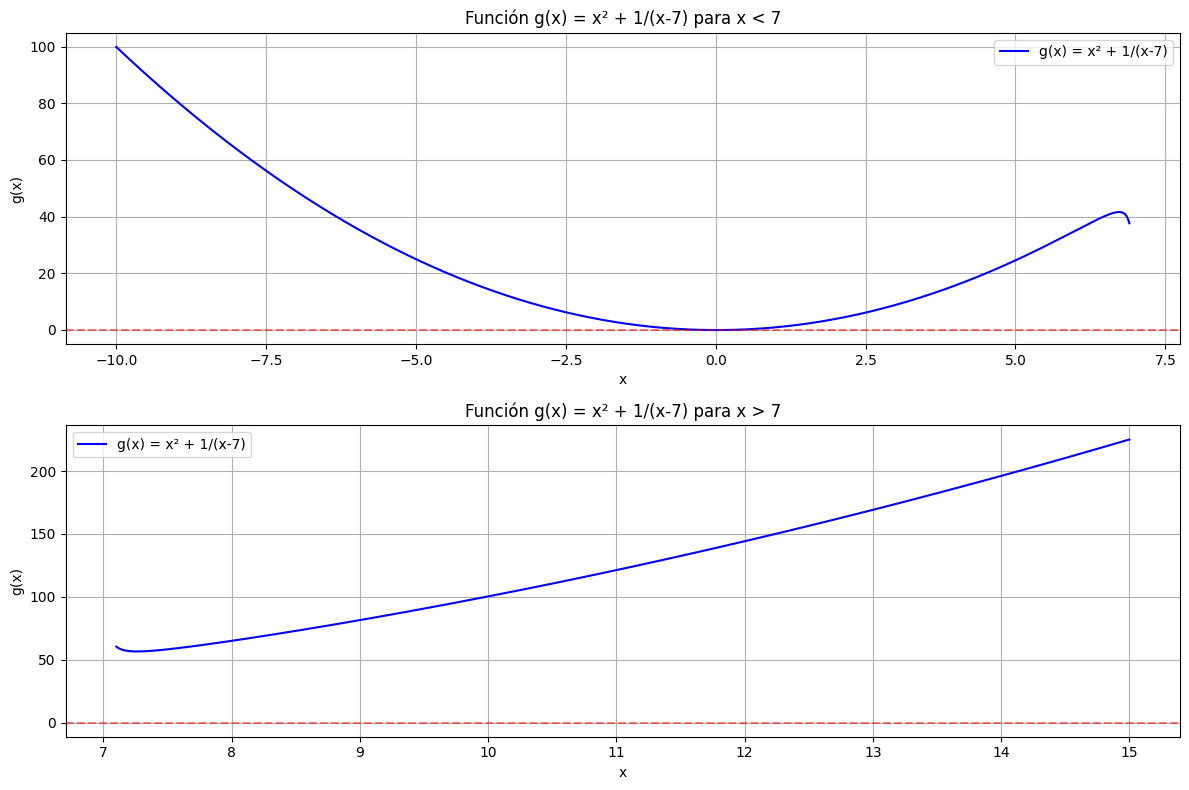

Evaluación de g(x) en algunos puntos:
g(-5) = 24.9167
g(-2) = 3.8889
g(0) = -0.1429
g(2) = 3.8000
g(5) = 24.5000
g(6) = 35.0000
g(8) = 65.0000
g(10) = 100.3333
g(12) = 144.2000


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Definir la función g(x) = x^2 + 1/(x - 7)
def g(x):
    return x**2 + 1/(x - 7)

# Derivada de g(x): g'(x) = 2x - 1/(x - 7)^2
def dg(x):
    return 2*x - 1/(x - 7)**2

# Primero, analicemos la función para identificar los intervalos donde pueden estar los ceros
# La función tiene una asíntota vertical en x = 7, así que necesitamos buscar en (-∞, 7) y (7, ∞)

# Graficar la función para visualizar los ceros
x1 = np.linspace(-10, 6.9, 1000)
x2 = np.linspace(7.1, 15, 1000)

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(x1, g(x1), 'b-', label='g(x) = x² + 1/(x-7)')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.grid(True)
plt.title('Función g(x) = x² + 1/(x-7) para x < 7')
plt.xlabel('x')
plt.ylabel('g(x)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(x2, g(x2), 'b-', label='g(x) = x² + 1/(x-7)')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.grid(True)
plt.title('Función g(x) = x² + 1/(x-7) para x > 7')
plt.xlabel('x')
plt.ylabel('g(x)')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluar la función en algunos puntos para identificar cambios de signo
print("Evaluación de g(x) en algunos puntos:")
puntos_test = [-5, -2, 0, 2, 5, 6, 8, 10, 12]
for x in puntos_test:
    if x != 7:  # Evitar la asíntota
        print(f"g({x}) = {g(x):.4f}")

In [6]:
# Aplicar los tres métodos para encontrar el cero de g(x) con 7 decimales de precisión
print("="*60)
print("BÚSQUEDA DEL CERO DE g(x) = x² + 1/(x-7)")
print("="*60)

# Parámetros para 7 decimales de precisión
tol = 1e-7
iter_max = 100

# 1. MÉTODO DE BISECCIÓN
print("\n1. MÉTODO DE BISECCIÓN")
print("-" * 25)
# Usamos el intervalo [-2, 0] donde la función cambia de signo
a, b = -2, 0
try:
    aprox_biseccion, raiz_biseccion = metodo_biseccion(g, a, b, tol, iter_max)
    print(f"Intervalo inicial: [{a}, {b}]")
    print(f"Número de iteraciones: {len(aprox_biseccion)}")
    print(f"Raíz encontrada: {raiz_biseccion:.7f}")
    print(f"Verificación g({raiz_biseccion:.7f}) = {g(raiz_biseccion):.2e}")
except Exception as e:
    print(f"Error en bisección: {e}")

# 2. MÉTODO DE LA SECANTE
print("\n2. MÉTODO DE LA SECANTE")
print("-" * 25)
# Usamos dos puntos iniciales cercanos al cero
x0, x1 = -2, 0
try:
    aprox_secante, raiz_secante = metodo_secante(g, x0, x1, tol, iter_max)
    print(f"Puntos iniciales: x0 = {x0}, x1 = {x1}")
    print(f"Número de iteraciones: {len(aprox_secante)}")
    print(f"Raíz encontrada: {raiz_secante:.7f}")
    print(f"Verificación g({raiz_secante:.7f}) = {g(raiz_secante):.2e}")
except Exception as e:
    print(f"Error en secante: {e}")

# 3. MÉTODO DE NEWTON-RAPHSON
print("\n3. MÉTODO DE NEWTON-RAPHSON")
print("-" * 30)
# Usamos un punto inicial cercano al cero
x0 = -1
try:
    aprox_newton, raiz_newton = metodo_newton(g, dg, x0, tol, iter_max)
    print(f"Punto inicial: x0 = {x0}")
    print(f"Número de iteraciones: {len(aprox_newton)}")
    print(f"Raíz encontrada: {raiz_newton:.7f}")
    print(f"Verificación g({raiz_newton:.7f}) = {g(raiz_newton):.2e}")
except Exception as e:
    print(f"Error en Newton: {e}")

# COMPARACIÓN DE RESULTADOS
print("\n" + "="*60)
print("COMPARACIÓN DE MÉTODOS")
print("="*60)
print(f"{'Método':<20} {'Iteraciones':<12} {'Raíz (7 decimales)':<20}")
print("-" * 52)
print(f"{'Bisección':<20} {len(aprox_biseccion):<12} {raiz_biseccion:.7f}")
print(f"{'Secante':<20} {len(aprox_secante):<12} {raiz_secante:.7f}")
print(f"{'Newton-Raphson':<20} {len(aprox_newton):<12} {raiz_newton:.7f}")

# Verificar que todos convergen al mismo valor
diferencia_max = max(abs(raiz_biseccion - raiz_secante), 
                    abs(raiz_biseccion - raiz_newton), 
                    abs(raiz_secante - raiz_newton))
print(f"\nDiferencia máxima entre métodos: {diferencia_max:.2e}")

if diferencia_max < 1e-6:
    print("✓ Todos los métodos convergen al mismo resultado")
else:
    print("⚠ Los métodos tienen diferencias significativas")

BÚSQUEDA DEL CERO DE g(x) = x² + 1/(x-7)

1. MÉTODO DE BISECCIÓN
-------------------------
Intervalo inicial: [-2, 0]
Número de iteraciones: 20
Raíz encontrada: -0.3683949
Verificación g(-0.3683949) = -1.55e-09

2. MÉTODO DE LA SECANTE
-------------------------
Puntos iniciales: x0 = -2, x1 = 0
Número de iteraciones: 11
Raíz encontrada: -0.3683948
Verificación g(-0.3683948) = -6.96e-08

3. MÉTODO DE NEWTON-RAPHSON
------------------------------
Punto inicial: x0 = -1
Número de iteraciones: 6
Raíz encontrada: -0.3683949
Verificación g(-0.3683949) = 6.45e-12

COMPARACIÓN DE MÉTODOS
Método               Iteraciones  Raíz (7 decimales)  
----------------------------------------------------
Bisección            20           -0.3683949
Secante              11           -0.3683948
Newton-Raphson       6            -0.3683949

Diferencia máxima entre métodos: 9.21e-08
✓ Todos los métodos convergen al mismo resultado


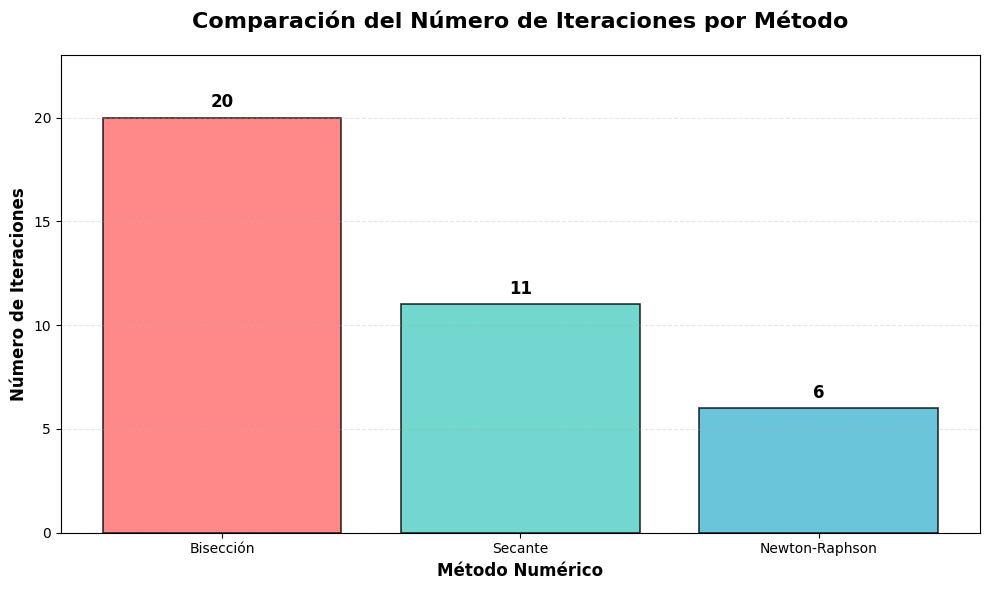


ESTADÍSTICAS DE CONVERGENCIA
Bisección      :  20 iteraciones
Secante        :  11 iteraciones
Newton-Raphson :   6 iteraciones

Método más eficiente: Newton-Raphson (6 iteraciones)
Diferencia máxima: 14 iteraciones
Factor de mejora: 3.3x (el mejor es 3.3 veces más rápido que el peor)


In [7]:
# Gráfico de barras comparando el número de iteraciones
plt.figure(figsize=(10, 6))

# Datos para el gráfico
metodos = ['Bisección', 'Secante', 'Newton-Raphson']
iteraciones = [len(aprox_biseccion), len(aprox_secante), len(aprox_newton)]
colores = ['#FF6B6B', '#4ECDC4', '#45B7D1']  # Rojo, verde azulado, azul

# Crear el gráfico de barras
barras = plt.bar(metodos, iteraciones, color=colores, alpha=0.8, edgecolor='black', linewidth=1.2)

plt.title('Comparación del Número de Iteraciones por Método', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Número de Iteraciones', fontsize=12, fontweight='bold')
plt.xlabel('Método Numérico', fontsize=12, fontweight='bold')

for i, (barra, valor) in enumerate(zip(barras, iteraciones)):
    plt.text(barra.get_x() + barra.get_width()/2, barra.get_height() + 0.3, 
             str(valor), ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.grid(axis='y', alpha=0.3, linestyle='--')

# Ajustar el rango del eje Y para mejor visualización
plt.ylim(0, max(iteraciones) * 1.15)

# Mejorar el diseño
plt.tight_layout()

# Mostrar el gráfico
plt.show()

# Mostrar estadísticas adicionales
print("\n" + "="*50)
print("ESTADÍSTICAS DE CONVERGENCIA")
print("="*50)
for metodo, iter_count in zip(metodos, iteraciones):
    print(f"{metodo:<15}: {iter_count:>3} iteraciones")

print(f"\nMétodo más eficiente: {metodos[iteraciones.index(min(iteraciones))]} ({min(iteraciones)} iteraciones)")
print(f"Diferencia máxima: {max(iteraciones) - min(iteraciones)} iteraciones")

# Calcular factor de mejora
factor_mejora = max(iteraciones) / min(iteraciones)
print(f"Factor de mejora: {factor_mejora:.1f}x (el mejor es {factor_mejora:.1f} veces más rápido que el peor)")

# Ejercicio 6



# Ejercicio 7

# Ejercicio 8

In [1]:
import numpy as np

def newton_multidimensional(F, J, x0, tol=1e-7, iter_max=50):
    """
    Newton-Raphson para F: R^n -> R^n con Jacobiano J.
    Devuelve la lista de aproximaciones y la solución final.
    """
    aproximaciones = [x0.copy()]
    x = x0.copy()
    for k in range(iter_max):
        Fx = F(x)
        Jx = J(x)
        # resolver J Δx = -F
        delta = np.linalg.solve(Jx, -Fx)
        x = x + delta
        aproximaciones.append(x.copy())
        if np.linalg.norm(delta, ord=2) < tol:
            break
    return aproximaciones, x

# Definimos F y su Jacobiano J
def F(u):
    x, y, z = u
    return np.array([
        3*x - np.cos(y*z) - 0.5,
        x**2 - 81*(y + 0.1)**2 + np.sin(z) + 1.06,
        np.exp(-x*y) + 20*z + (10*np.pi - 3)/3
    ])

def J(u):
    x, y, z = u
    return np.array([
        [ 3,
          np.sin(y*z)*z,
          np.sin(y*z)*y ],
        [ 2*x,
         -162*(y + 0.1),
          np.cos(z) ],
        [ -y*np.exp(-x*y),
          -x*np.exp(-x*y),
           20 ]
    ])

# Ejecutamos con un guess inicial razonable
x0 = np.array([0.1, 0.1, 0.0])
aprox_list, raiz = newton_multidimensional(F, J, x0)

print("Solución (7 decimales):", np.round(raiz, 7))


Solución (7 decimales): [ 0.5        0.        -0.5235988]
